# Step 1, Load Data
Importing neccessary libraries and loading data for future use

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()
from ipywidgets import interact, fixed

import pandas as pd
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_csv('Dataset.csv')
data = data.to_numpy()
print(data)
print(data.shape)

[[-0.15899   0.42398   1.        0.       -0.35306  -0.6739  ]
 [-0.34793   0.47076   1.        1.       -0.22713   0.44732 ]
 [-0.50461   0.3538    1.        0.        0.092898 -0.75352 ]
 ...
 [-0.31694  -0.22895   1.             nan       nan       nan]
 [-0.29412  -0.13479   0.             nan       nan       nan]
 [-0.15311   0.1845    0.             nan       nan       nan]]
(211, 6)


In [ ]:
X_train = data[: , :2]
y_train = data[:, 2]

X_test = data[:200, 4:6]
y_test = data[:200, 3]
print("X train: ",X_train[:5])
print("Y train: ", y_train[:5])
print("X test: ", X_test[:5])
print("y test: ", y_test[:5])

X train:  [[-0.15899  0.42398]
 [-0.34793  0.47076]
 [-0.50461  0.3538 ]
 [-0.59677  0.11403]
 [-0.51843 -0.17252]]
Y train:  [1. 1. 1. 1. 1.]
X test:  [[-0.35306   -0.6739   ]
 [-0.22713    0.44732  ]
 [ 0.092898  -0.75352  ]
 [ 0.14824   -0.71847  ]
 [-0.0015125  0.16293  ]]
y test:  [0. 1. 0. 0. 0.]


Implementing plotting functions for future use

In [ ]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca() #create a new axis if there is no axis in the fig.
    xlim = ax.get_xlim() #if there is an axis, get the x-axis limit
    ylim = ax.get_ylim() #if there is an axis, get the x-axis limit

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape) #Evaluate the decision function for the samples in xy.

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

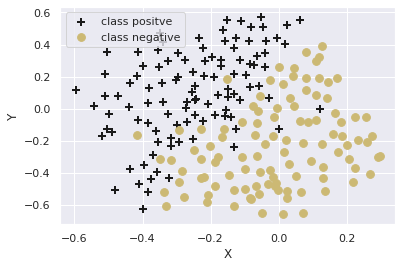

In [ ]:
plotData(data[:, :3], "X", "Y", "class positve", "class negative")

**Can a linear SVC be used to classify this data?**
Yes, when looking at the graph it appears that the data is mostly linearly seperable. However, it would not be a perfect separation. as there are a few outliers.

# SVM Train and Hyperparameter Optimization
In this section I will be training the dataset, as well as finding the optimal hyperparameters.

First, I'll make the SVC model

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC()

Here I am using RepeatedKFold to create cross validation data using the training data.

In [ ]:
cv = RepeatedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
cv.get_n_splits(X_train, X_test)

15

Creating the search space for tuned parameters.

In [ ]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

In [ ]:
search = RandomizedSearchCV(model, tuned_parameters, n_iter = 16, scoring = 'accuracy', cv = cv, random_state = 1)

Fitting the data finally.

In [ ]:
initial_search = search.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 12 is smaller than n_iter=16. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
print('Best Score: %s' % initial_search.best_score_)
print('Best Hyperparameters: %s' % initial_search.best_params_)

Best Score: 0.9225913621262459
Best Hyperparameters: {'kernel': 'linear', 'C': 10}


**What is the optimal kernel function and C value?**

Kernel: linear
C value: 10

**Do these choices make sense?**

The kernel being linear makes sense as the data is linearly seperable, and the C value makes sense as the accuracy is very high.

# Retraining
Here I am retraining using information from old labs.

In [ ]:
clf = SVC(kernel='linear', C=10)
clf.fit(X_train, y_train)

SVC(C=10, kernel='linear')

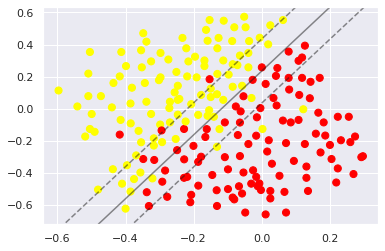

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

In [ ]:
y_pred = clf.predict(X_test)
y_pred

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94       113
         1.0       0.95      0.90      0.92        87

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



**Performance**

The model performed very well, as the precision is at 92% and an F1 score of 94%. The model does well in indentifying both positive and negative cases.